In [1]:
import os,sys
import numpy as np
import copy
import time
import h5py
import pandas as pd


from sklearn import decomposition
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

codepath = '/user_data/mmhender/imStat/code'
sys.path.append(codepath)
from utils import nsd_utils, default_paths
# import coco_utils
import PIL
import matplotlib.pyplot as plt
from matplotlib import cm
from model_fitting import initialize_fitting
from plotting_and_analysis import plot_utils
from feature_extraction import pca_feats
from utils import numpy_utils

In [2]:
# cat_objects, cat_names, cat_ids, supcat_names, ids_each_supcat = coco_utils.get_coco_cat_info()

subject = 1;
fn2load = os.path.join(default_paths.sketch_token_feat_path, 'LDA','S%d_LDA_all_supcat.npy'%subject)
result = np.load(fn2load, allow_pickle=True).item()

lda_scores_each_prf = result['scores']
lda_wts_each_prf = result['wts']
lda_pre_mean_each_prf = result['pre_mean']

trn_acc_each_prf = result['trn_acc']
trn_acc_each_prf = result['trn_dprime']
val_acc_each_prf = result['val_acc']
val_acc_each_prf = result['val_dprime']
labels_pred_each_prf = result['labels_pred'];
labels_actual_each_prf = result['labels_actual'];


In [3]:

subject = 1;
fn2load = os.path.join(default_paths.sketch_token_feat_path, 'PCA','S%d_PCA.npy'%subject)
pc_result = np.load(fn2load, allow_pickle=True).item()

pca_scores_each_prf = pc_result['scores']
pca_wts_each_prf = pc_result['wts']
pca_pre_mean_each_prf = pc_result['pre_mean']

ev_each_prf = pc_result['ev']

In [4]:
# training / validation data always split the same way - shared 1000 inds are validation.
subject_df = nsd_utils.get_subj_df(subject)
valinds = np.array(subject_df['shared1000'])
trninds = np.array(subject_df['shared1000']==False)

In [5]:
mm=697

path_to_load = default_paths.sketch_token_feat_path
features_file = os.path.join(path_to_load, 'S%d_features_each_prf.h5py'%(subject))
print('Loading pre-computed features from %s'%features_file)
t = time.time()
with h5py.File(features_file, 'r') as data_set:
    values = np.copy(data_set['/features'][:,:,mm])
    data_set.close() 
elapsed = time.time() - t
print('Took %.5f seconds to load file'%elapsed)
features_each_prf = values[:,:,np.newaxis]

Loading pre-computed features from /user_data/mmhender/features/sketch_tokens/S1_features_each_prf.h5py
Took 23.07056 seconds to load file


In [6]:
pca_scores = pca_scores_each_prf[mm]
pca_wts = pca_wts_each_prf[mm]
pca_pre_mean = pca_pre_mean_each_prf[mm]

features_in_prf = features_each_prf[:,:,0]
zgroup_labels = np.concatenate([np.zeros(shape=(1,150)), np.ones(shape=(1,1))], axis=1)
features_in_prf_z = numpy_utils.zscore_in_groups(features_in_prf, zgroup_labels)

In [7]:
n = np.sum(trninds)
var_each_comp = np.var(pca_scores[trninds,:], axis=0)
sv = np.sqrt((var_each_comp)*(n-1))
expl_var_trn = sv**2/np.sum(sv**2)*100

In [8]:
n = np.sum(trninds)
var_each_comp = np.var(pca_scores[valinds,:], axis=0)
sv = np.sqrt((var_each_comp)*(n-1))
expl_var_val = sv**2/np.sum(sv**2)*100

In [9]:
ncomp_max = pca_scores.shape[1]
ncomp_vals = np.arange(0, ncomp_max)
pca_r2_trn_by_ncomp = np.zeros((len(ncomp_vals),))
for ii, nc in enumerate(ncomp_vals):
    recon_trn = pca_scores[trninds,0:nc] @ pca_wts[0:nc,:] + \
                    np.tile(pca_pre_mean[np.newaxis,:], [np.sum(trninds),1])
    ssr = np.sum((recon_trn-features_in_prf_z[trninds,:])**2)
    sst = np.sum((features_in_prf_z[trninds,:] - np.mean(features_in_prf_z[trninds,:]))**2)
    r2_trn = 1-ssr/sst
    pca_r2_trn_by_ncomp[ii] = r2_trn

In [10]:
ncomp_max = pca_scores.shape[1]
ncomp_vals = np.arange(0, ncomp_max)
pca_r2_val_by_ncomp = np.zeros((len(ncomp_vals),))
for ii, nc in enumerate(ncomp_vals):
    recon_val = pca_scores[valinds,0:nc] @ pca_wts[0:nc,:] + \
                    np.tile(pca_pre_mean[np.newaxis,:], [np.sum(valinds),1])
    ssr = np.sum((recon_val-features_in_prf_z[valinds,:])**2)
    sst = np.sum((features_in_prf_z[valinds,:] - np.mean(features_in_prf_z[valinds,:]))**2)
    r2_val = 1-ssr/sst
    pca_r2_val_by_ncomp[ii] = r2_val

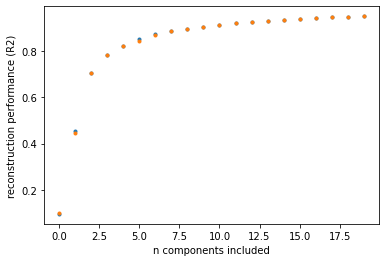

In [11]:
plt.figure();
plt.plot(ncomp_vals[0:20], pca_r2_trn_by_ncomp[0:20],'.')
plt.plot(ncomp_vals[0:20], pca_r2_val_by_ncomp[0:20],'.')
plt.xlabel('n components included');
plt.ylabel('reconstruction performance (R2)');

In [12]:
lda_scores = lda_scores_each_prf[mm]
lda_wts = lda_wts_each_prf[mm]
lda_pre_mean = lda_pre_mean_each_prf[mm]

features_in_prf = features_each_prf[:,:,0]
zgroup_labels = np.concatenate([np.zeros(shape=(1,150)), np.ones(shape=(1,1))], axis=1)
features_in_prf_z = numpy_utils.zscore_in_groups(features_in_prf, zgroup_labels)

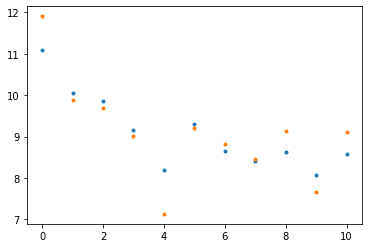

In [13]:
n = np.sum(trninds)
var_each_comp = np.var(lda_scores[trninds,:], axis=0)
sv = np.sqrt((var_each_comp)*(n-1))
expl_var_trn = sv**2/np.sum(sv**2)*100

n = np.sum(trninds)
var_each_comp = np.var(lda_scores[valinds,:], axis=0)
sv = np.sqrt((var_each_comp)*(n-1))
expl_var_val = sv**2/np.sum(sv**2)*100

plt.figure();
plt.plot(expl_var_trn[0:20],'.')
plt.plot(expl_var_val[0:20],'.')

In [15]:
ncomp_max = lda_scores.shape[1]
ncomp_vals = np.arange(0, ncomp_max)
lda_r2_trn_by_ncomp = np.zeros((len(ncomp_vals),))
for ii, nc in enumerate(ncomp_vals):
    pinvwts = np.linalg.pinv(lda_wts)
    recon_trn = (lda_scores[trninds,0:nc] @ pinvwts[0:nc,:]) + \
                    np.tile(lda_pre_mean[np.newaxis,:], [np.sum(trninds), 1])
    
#     recon_trn = (lda_scores[trninds,0:nc] @ np.linalg.pinv(lda_wts[:,0:nc])) + \
#                     np.tile(lda_pre_mean[np.newaxis,:], [np.sum(trninds), 1])
    
    ssr = np.sum((recon_trn-features_in_prf_z[trninds,:])**2)
    sst = np.sum((features_in_prf_z[trninds,:] - np.mean(features_in_prf_z[trninds,:]))**2)
    r2_trn = 1-ssr/sst
    lda_r2_trn_by_ncomp[ii] = r2_trn

In [16]:
ncomp_max = lda_scores.shape[1]
ncomp_vals = np.arange(0, ncomp_max)
lda_r2_val_by_ncomp = np.zeros((len(ncomp_vals),))
for ii, nc in enumerate(ncomp_vals):
    pinvwts = np.linalg.pinv(lda_wts)
    recon_val = (lda_scores[valinds,0:nc] @ pinvwts[0:nc,:]) + \
                    np.tile(lda_pre_mean[np.newaxis,:], [np.sum(valinds), 1])
#     recon_val = (lda_scores[valinds,0:nc] @ np.linalg.pinv(lda_wts[:,0:nc])) + \
#                     np.tile(lda_pre_mean[np.newaxis,:], [np.sum(valinds), 1])
    
    ssr = np.sum((recon_val-features_in_prf_z[valinds,:])**2)
    sst = np.sum((features_in_prf_z[valinds,:] - np.mean(features_in_prf_z[valinds,:]))**2)
    r2_val = 1-ssr/sst
    lda_r2_val_by_ncomp[ii] = r2_val

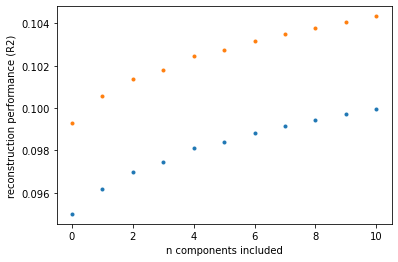

In [17]:
plt.figure();
plt.plot(ncomp_vals[0:20], lda_r2_trn_by_ncomp[0:20],'.')
plt.plot(ncomp_vals[0:20], lda_r2_val_by_ncomp[0:20],'.')
plt.xlabel('n components included');
plt.ylabel('reconstruction performance (R2)');

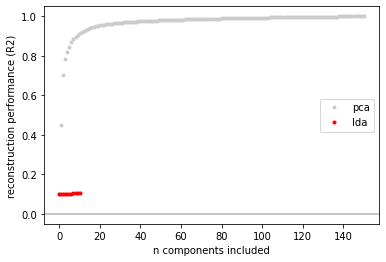

In [18]:
plt.figure();
# plt.plot(np.arange(0,151),pca_r2_trn_by_ncomp,'.')
plt.plot(np.arange(0,151), pca_r2_val_by_ncomp,'.',color=[0.8, 0.8, 0.8])
# plt.plot(np.arange(0,11), lda_r2_trn_by_ncomp,'.')
plt.plot(np.arange(0,11), lda_r2_val_by_ncomp,'.',color = 'r')
plt.xlabel('n components included');
plt.ylabel('reconstruction performance (R2)');

plt.legend(['pca','lda'])
plt.axhline(0, color=[0.7, 0.7, 0.7])

In [19]:
v = np.random.normal(0,1,(10,1))
pv = np.linalg.pinv(v)
print(v)
print(pv)

[[ 1.6340455 ]
 [ 0.96209578]
 [ 1.46722522]
 [ 0.81974413]
 [ 0.02923954]
 [-0.63274642]
 [-0.06363498]
 [-0.429099  ]
 [ 0.07198993]
 [-0.23907837]]
[[ 0.23105185  0.13603906  0.20746369  0.11591072  0.00413443 -0.0894695
  -0.0089979  -0.06067403  0.01017928 -0.03380536]]


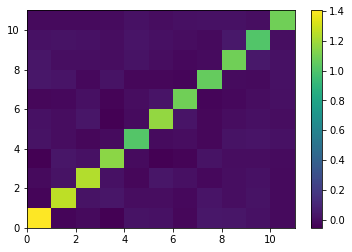

In [69]:
covmat = np.cov(lda_scores.T)
plt.figure();
plt.pcolormesh(covmat)
plt.colorbar()

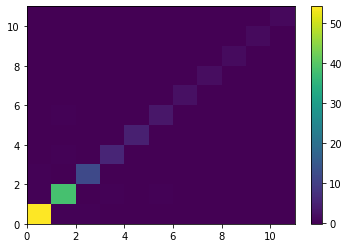

In [71]:
covmat = np.cov(pca_scores.T)
plt.figure();
plt.pcolormesh(covmat[0:11,0:11])
plt.colorbar()

In [46]:
# Testing with random data to verify it can perfectly reconstruct

tst_features = np.random.normal(0,1,[100,10])
zgroup_labels = np.concatenate([np.zeros(shape=(1,9)), np.ones(shape=(1,1))], axis=1)
tstfeatures_z = numpy_utils.zscore_in_groups(tst_features, zgroup_labels)

pca = decomposition.PCA(n_components = 10, copy=True)
scores = pca.fit_transform(tstfeatures_z) 
wts = pca.components_
ev = pca.explained_variance_
ev = ev/np.sum(ev)*100
premean = pca.mean_ 

In [47]:
ncomp = np.arange(0,11)
r2 = np.zeros((len(ncomp), ))
for ii, nc in enumerate(ncomp):

    tstfeat_pred = scores[:,0:nc] @ wts[0:nc,:] + np.tile(premean[np.newaxis,:], [100,1])

    ssr = np.sum((tstfeat_pred-tstfeatures_z)**2)
    sst = np.sum((tstfeatures_z - np.mean(tstfeatures_z))**2)
    print(1-ssr/sst)
    
    r2[ii] = 1-ssr/sst

0.010645192364625466
0.16778763250686757
0.3167233804996147
0.43338968495282326
0.5422695372444777
0.6476951111196647
0.7385332550966794
0.8225796923804662
0.8913248845155058
0.9518487505939864
1.0


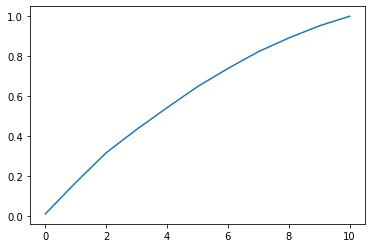

In [48]:
plt.figure();
plt.plot(ncomp, r2)

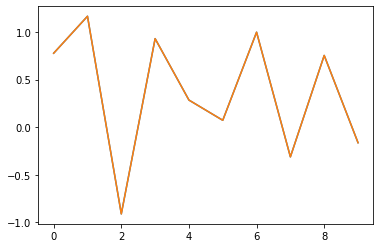

In [49]:
plt.figure();
plt.plot(tstfeatures_z[0,:])
plt.plot(tstfeat_pred[0,:])

In [60]:
# Testing LDA reconstruction - can be perfect when nclasses = nfeat+1
# but much worse when fewer classes...
nfeat = 139
ntrials = 300
nclasses = 140
tst_features = np.random.normal(0,1,[ntrials,nfeat])
zgroup_labels = np.concatenate([np.zeros(shape=(1,nfeat-1)), np.ones(shape=(1,1))], axis=1)
tstfeatures_z = numpy_utils.zscore_in_groups(tst_features, zgroup_labels)


In [61]:

X = tstfeatures_z; y = np.tile(np.arange(nclasses),int(np.ceil(ntrials/nclasses)))[0:X.shape[0]]
clf = LinearDiscriminantAnalysis(solver='svd')
clf.fit(X, y)

scores = clf.transform(X)   

scalings = clf.scalings_
xbar = clf.xbar_
coef = clf.coef_

In [63]:
nc = 140
pinvw = np.linalg.pinv(scalings)
recon = (scores[:,0:nc] @ pinvw[0:nc,:]) + np.tile(xbar[np.newaxis,:], [ntrials, 1])

In [64]:
ssr = np.sum((recon-tstfeatures_z)**2)
sst = np.sum((tstfeatures_z - np.mean(tstfeatures_z))**2)
print(1-ssr/sst)

1.0


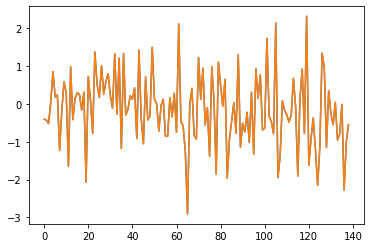

In [65]:
plt.figure();
plt.plot(tstfeatures_z[0,:])
plt.plot(recon[0,:])

In [33]:
# recon = (scores @ np.linalg.pinv(scalings)) + np.tile(xbar[np.newaxis,:], [ntrials, 1])

In [25]:
# nc = 130
# recon = (scores[:,0:nc] @ np.linalg.pinv(scalings[:,0:nc])) + np.tile(xbar[np.newaxis,:], [ntrials, 1])

In [26]:
# ssr = np.sum((recon-tstfeatures_z)**2)
# sst = np.sum((tstfeatures_z - np.mean(tstfeatures_z))**2)
# print(1-ssr/sst)

In [27]:
# pinvw.shape